## Objective ##

In this project, the goal is to predict the future housing market in Salt Lake City, UT, using the dataset provided by Zillow.


## Assumptions: 

External variables like interest rate, CPI, etc., influence housing prices in a stable way. Without this assumption, correlation ≠ prediction

The 24-month forecast is based on patterns learned from historical trends and simulated regressors.

There are no major economic or political shocks	Pandemics, wars, etc., would break the model

We incorporate real-time mortgage rates, unemployment, housing inventory, and permit data

The model accounts for yearly seasonality but not daily or weekly trends, which are typically irrelevant for long-term housing forecasts.

Price tier effects are averaged or segmented separately	if using averages, model won’t capture luxury vs. entry-level divergence unless included explicitly ##

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
slc_df=pd.read_csv("slc_df.csv")

In [4]:
slc_df=slc_df.dropna()

In [5]:
slc_df = slc_df[slc_df['RegionName'] == 'Salt Lake City']

In [6]:
slc_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31
160,6909,161,Salt Lake City,city,UT,UT,"Salt Lake City, UT",Salt Lake County,168624.96873,168688.71397,...,550249.904643,551100.266781,551094.511448,551626.977219,552029.877234,553119.740045,554484.467703,555905.797608,556341.397001,556031.869839


## Time Series for housing price in SLC

In [153]:

#I name my dataframe slc_df as indicated above. 

# Get a list of column names representing months
date_cols = slc_df.columns[slc_df.columns.str.contains(r'\d{4}-\d{2}-\d{2}')]
# slc_df.columns: This retrieves all column names from the DataFrame slc_df.

# str.contains(): This is a string method used to check if each column name contains a specific pattern.

# r'\d{4}-\d{2}-\d{2}': This is a regular expression (regex) pattern. It matches strings that represent dates in the format YYYY-MM-DD.
# \d{4}: Matches exactly 4 digits (representing the year).
# -: Matches a literal hyphen.
# \d{2}: Matches exactly 2 digits (representing the month).
# -: Matches another literal hyphen.
# \d{2}: Matches exactly 2 digits (representing the day).

# Purpose: The melt method reshape the DataFrame from a wide format to a long format.
# Wide Format: Each date is a separate column, with corresponding values for each row.
# Long Format: Dates are combined into a single column (Date), and their values are stored in another column (HousePriceIndex).

# Melt the DataFrame, specifying the columns to keep as identifiers
# Remove 'StateMetro' from id_vars if it's not present
melted_df = slc_df.melt(
    id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'CountyName'],
    value_vars=date_cols,  # Specify the columns to melt
    var_name='Date',
    value_name='HousePriceIndex'
)

# Convert 'Date' column to datetime format
melted_df['Date'] = pd.to_datetime(melted_df['Date'])

print(melted_df)

     RegionID  SizeRank      RegionName RegionType StateName  \
0        6909       161  Salt Lake City       city        UT   
1        6909       161  Salt Lake City       city        UT   
2        6909       161  Salt Lake City       city        UT   
3        6909       161  Salt Lake City       city        UT   
4        6909       161  Salt Lake City       city        UT   
..        ...       ...             ...        ...       ...   
290      6909       161  Salt Lake City       city        UT   
291      6909       161  Salt Lake City       city        UT   
292      6909       161  Salt Lake City       city        UT   
293      6909       161  Salt Lake City       city        UT   
294      6909       161  Salt Lake City       city        UT   

           CountyName       Date  HousePriceIndex  
0    Salt Lake County 2000-01-31    168624.968730  
1    Salt Lake County 2000-02-29    168688.713970  
2    Salt Lake County 2000-03-31    168871.693666  
3    Salt Lake County 2

In [154]:
slc_df.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName', '2000-01-31', '2000-02-29',
       ...
       '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31', '2024-02-29',
       '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30', '2024-07-31'],
      dtype='object', length=303)

## Exploratory Data Analysis (EDA)

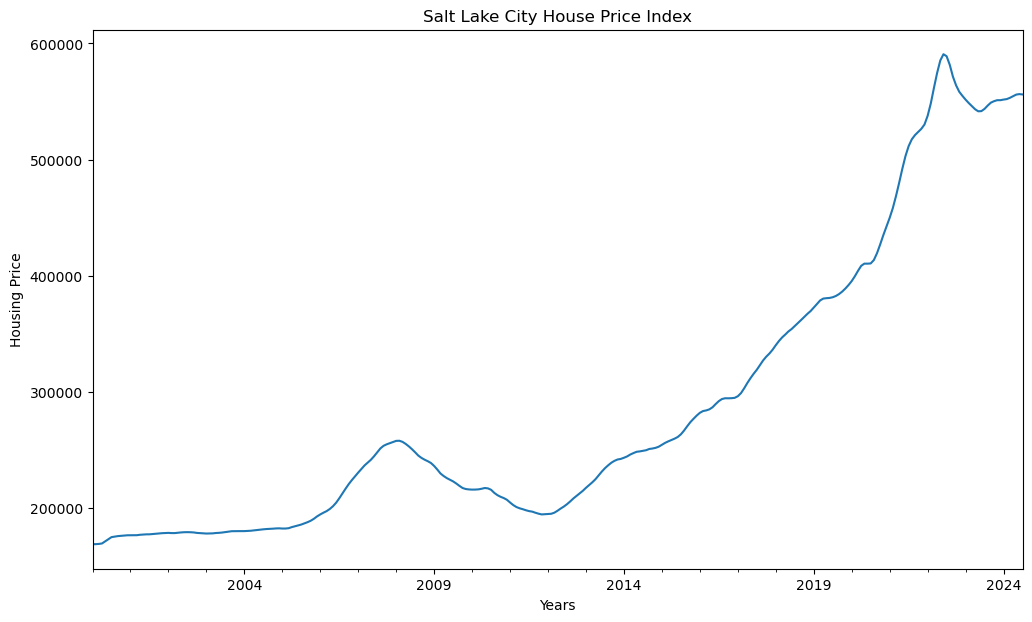

       RegionID  SizeRank  HousePriceIndex
count     295.0     295.0       295.000000
mean     6909.0     161.0    286986.939184
std         0.0       0.0    123650.189569
min      6909.0     161.0    168624.968730
25%      6909.0     161.0    194397.090266
50%      6909.0     161.0    240448.866245
75%      6909.0     161.0    352958.287058
max      6909.0     161.0    590692.910623


In [155]:
# Visualize the time series data to understand its behavior.
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the time series
# Set 'Date' as the index, which is the x-axis in the plot
melted_df.set_index('Date', inplace=True)
# Plot the time series
#By default, HousePriceIndex.plot will set the values from HousePriceIndex as the y-axis.
melted_df['HousePriceIndex'].plot(figsize=(12, 7))
plt.title('Salt Lake City House Price Index')
plt.ylabel('Housing Price')
plt.xlabel('Years')
plt.show()

# Calculate summary statistics
print(melted_df.describe())

In [156]:
print(melted_df[['RegionID', 'SizeRank']].drop_duplicates())

            RegionID  SizeRank
Date                          
2000-01-31      6909       161


### Year over year (YoY) percentage change (growth rate)

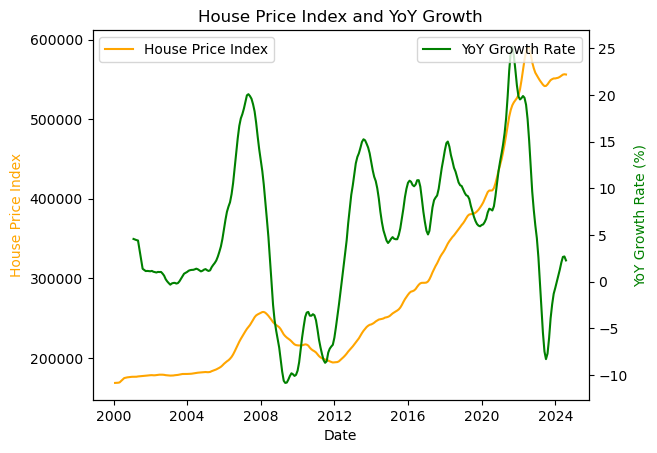

In [157]:
# Calculate year-over-year growth rate
melted_df['YoY_Growth'] = melted_df['HousePriceIndex'].pct_change(periods=12) * 100
#Takes the percentage difference between the current value and the value 12 months prior
# times 100 turns it into a percentage

# Plot the time series with year-over-year growth
fig, ax1 = plt.subplots()
ax1.plot(melted_df.index, melted_df['HousePriceIndex'], color='orange', label='House Price Index')
# ax1 = left y-axis (for price)
# ax2 = right y-axis (for growth %)

# Plots HousePriceIndex on the primary y-axis using the x-axis (Date from the DataFrame index).
ax1.set_xlabel('Date')
ax1.set_ylabel('House Price Index', color='orange')

# Creates a twin y-axis (secondary y-axis) to show the YoY_Growth alongside the HousePriceIndex.
ax2 = ax1.twinx()
ax2.plot(melted_df.index, melted_df['YoY_Growth'], color='green', label='YoY Growth Rate')
ax2.set_ylabel('YoY Growth Rate (%)', color='green')


ax1.legend(['House Price Index'], loc='upper left')
ax2.legend(['YoY Growth Rate'], loc='upper right')

plt.title('House Price Index and YoY Growth')
plt.show()

2008–2009: Negative growth due to the housing crash

2020–2022: Unusually high growth rates (20–25%), likely tied to pandemic-driven demand

2023–2024: A sharp correction, where growth rates briefly turn negative, signaling a market cooldown

In [43]:

# Perform ADF test on the original data
result = adfuller(melted_df['HousePriceIndex'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.6069990080540425
p-value: 0.9877868781815293


#### A p-value of 0.987 and an ADF (Augmented Dickey-Fuller) statistic of 0.606 indicate that your time series is non-stationary. In other words, the data has a trend, seasonality, or other characteristics that vary over time.

## Trend-only Time Series Forecasting
This method gives us the chance to understand the long-term trend without interference from seasonal patterns or external signals. This forecasting does not incorporate external factos like mortage rate, unemployment rate and permit, and we will incorporate them later in this analysis. 



18:31:47 - cmdstanpy - INFO - Chain [1] start processing
18:31:47 - cmdstanpy - INFO - Chain [1] done processing
/Users/henrylu/anaconda3/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/var/folders/tv/4h4r51tn40qfmk59wk5p1w5w0000gq/T/ipykernel_33735/1253338756.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


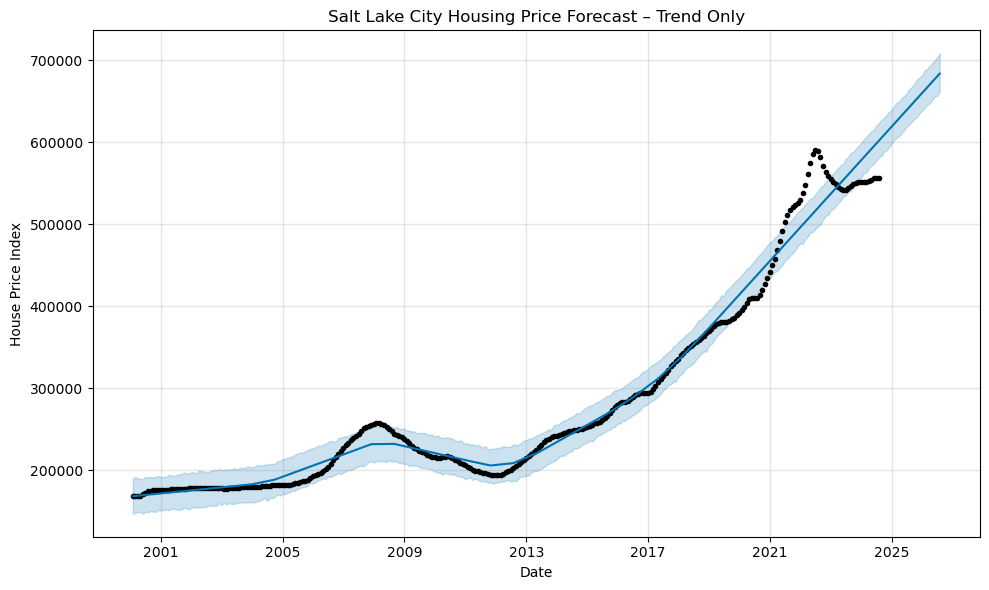

In [165]:
# 1. Prepare the data (reset index to get 'Date' back as a column)
df = melted_df.reset_index()[['Date', 'HousePriceIndex']].dropna().copy()
df.columns = ['ds', 'y']  # Prophet format

# 2. Initialize Prophet with no seasonality (trend-only)
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False
)
# 3. Fit the model
model.fit(df)

# 4. Make future dataframe (next 24 months)
future = model.make_future_dataframe(periods=24, freq='M')

# 5. Forecast
forecast = model.predict(future)

# 6. Plot
fig = model.plot(forecast)
plt.title("Salt Lake City Housing Price Forecast – Trend Only")
plt.xlabel("Date")
plt.ylabel("House Price Index")
plt.grid(True)
plt.tight_layout()
plt.show()

## Train model and forecast next 24 months widow

Using multiple variables (mortgage_rate, unemployment_rate, permits, and inventory) in addition to the target (HousePriceIndex to predict housing price for the next 24 months.

Incorporating ral-world data from Federal Reserve Bank datasets for mortgage rate, unemployment rate and new privately-owned housing united authroized in permit-issuing places. 
For this portion of the analysis, Prophet model is used using historical data and external regressors like mortgage rates, permits, or unemployment to forecast future housing price. 

### Multivariate Time Series Forecasting with External Regressors

In [168]:
# Load and prepare real macroeconomic regressors
mortgage = pd.read_csv('MORTGAGE30US.csv')
mortgage = mortgage.rename(columns={'observation_date': 'ds', 'MORTGAGE30US': 'mortgage_rate'})
mortgage['ds'] = pd.to_datetime(mortgage['ds'])

unemp = pd.read_csv('UNRATE.csv')
unemp = unemp.rename(columns={'observation_date': 'ds', 'UNRATE': 'unemployment_rate'})
unemp['ds'] = pd.to_datetime(unemp['ds'])

permits = pd.read_csv('PERMIT.csv')
permits = permits.rename(columns={'observation_date': 'ds', 'PERMIT': 'permits'})
permits['ds'] = pd.to_datetime(permits['ds'])
permits['inventory'] = None  # Optional placeholder

# Merge into one DataFrame
real_regressors = mortgage.merge(unemp, on='ds').merge(permits, on='ds')

# Scale to align with HPI magnitude
real_regressors['mortgage_rate'] = real_regressors['mortgage_rate'] / 100
real_regressors['unemployment_rate'] = real_regressors['unemployment_rate'] / 100
real_regressors['permits'] = real_regressors['permits'] / 1000

# Fill or drop NaNs in training set (use forward-fill first, then fallback to zero)
prophet_df[['mortgage_rate', 'unemployment_rate', 'permits', 'inventory']] = (
    prophet_df[['mortgage_rate', 'unemployment_rate', 'permits', 'inventory']]
    .fillna(method='ffill')
    .fillna(0)
)

/var/folders/tv/4h4r51tn40qfmk59wk5p1w5w0000gq/T/ipykernel_33735/862185220.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')


In [170]:
# Prepare Prophet training DataFrame
prophet_df = melted_df.reset_index()[['Date', 'HousePriceIndex']].dropna().copy()
prophet_df.columns = ['ds', 'y']

# Merge real regressors into training data
prophet_df = pd.merge(prophet_df, real_regressors, on='ds', how='left')

# Train model
model = Prophet(interval_width=0.70)
model.add_regressor('mortgage_rate')
model.add_regressor('unemployment_rate')
model.add_regressor('permits')
model.add_regressor('inventory')
# Fill or drop NaNs in training set (use forward-fill first, then fallback to zero)
prophet_df[['mortgage_rate', 'unemployment_rate', 'permits', 'inventory']] = (
    prophet_df[['mortgage_rate', 'unemployment_rate', 'permits', 'inventory']]
    .fillna(method='ffill')
    .fillna(0)
)
model.fit(prophet_df)

# Create future DataFrame
future = model.make_future_dataframe(periods=24, freq='ME')
future = pd.merge(future, real_regressors, on='ds', how='left')

# Fill future NaNs (forward-fill for continuity)
future[['mortgage_rate', 'unemployment_rate', 'permits', 'inventory']] = \
    future[['mortgage_rate', 'unemployment_rate', 'permits', 'inventory']].fillna(method='ffill').fillna(0)

# Generate forecast
forecast = model.predict(future)
forecast_only = forecast[forecast['ds'] > prophet_df['ds'].max()]

/var/folders/tv/4h4r51tn40qfmk59wk5p1w5w0000gq/T/ipykernel_33735/1929685668.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')
/var/folders/tv/4h4r51tn40qfmk59wk5p1w5w0000gq/T/ipykernel_33735/1929685668.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(method='ffill')
18:32:31 - cmdstanpy - INFO - Chain [1] start processing
18:32:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/tv/4h4r51tn40qfmk59wk5p1w5w0000gq/T/ipykernel_33735/1929685668.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future[['mortgage_rate', 'unemployment_rate', 'p

/var/folders/tv/4h4r51tn40qfmk59wk5p1w5w0000gq/T/ipykernel_33735/254189350.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/tv/4h4r51tn40qfmk59wk5p1w5w0000gq/T/ipykernel_33735/254189350.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


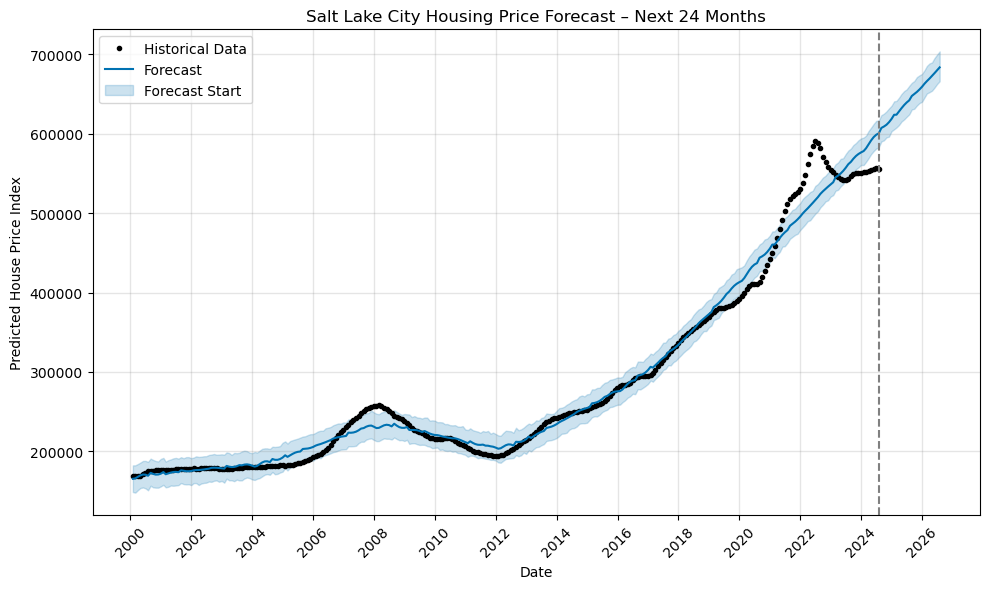

In [171]:
import matplotlib.dates as mdates

fig = model.plot(forecast)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.tight_layout()

forecast_start = prophet_df['ds'].max()
plt.axvline(x=forecast_start, color='gray', linestyle='--', label='Forecast Start')

plt.title("Salt Lake City Housing Price Forecast – Next 24 Months")
plt.xlabel("Date")
plt.ylabel("Predicted House Price Index")
plt.legend(["Historical Data", "Forecast", "Forecast Start"])
plt.grid(True)
plt.tight_layout()
plt.show()

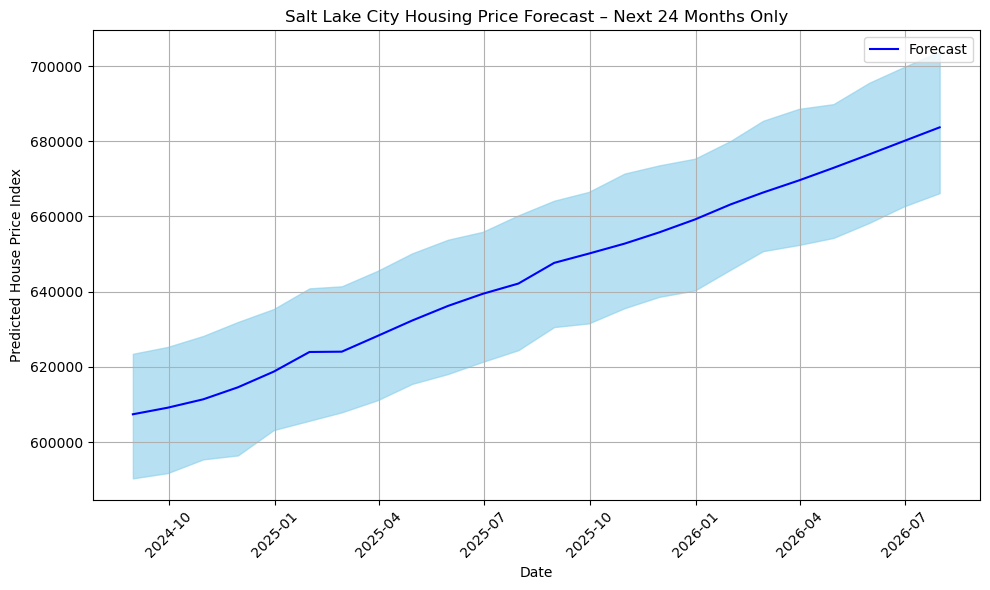

In [172]:
# Only show forecasted dates (after the training period)
forecast_start = prophet_df['ds'].max()
forecast_only = forecast[forecast['ds'] > forecast_start]

# Plot just the forecasted part
plt.figure(figsize=(10, 6))
plt.plot(forecast_only['ds'], forecast_only['yhat'], label='Forecast', color='blue')
plt.fill_between(forecast_only['ds'], forecast_only['yhat_lower'], forecast_only['yhat_upper'], color='skyblue', alpha=0.6)

# Customize
plt.title("Salt Lake City Housing Price Forecast – Next 24 Months Only")
plt.xlabel("Date")
plt.ylabel("Predicted House Price Index")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

 Black Dots = Actual Historical Data of Salt Lake City house prices by month from prophet_df['y']
 Blue Line  = Forecasted Trend (yhat)generated by model.predict(future)
 
 

In [173]:
start_price = forecast[forecast['ds'] == '2024-08-31']['yhat'].values[0]
end_price = forecast[forecast['ds'] == '2026-07-31']['yhat'].values[0]
years = 2
cagr = ((end_price / start_price) ** (1/years)) - 1
print(f"2 years growth rate: {cagr * 100:.2f}%")

2 years growth rate: 6.09%


Salt Lake City housing prices are projected to grow at an annualized rate of 6.04% over the next 24 months. This reflects current economic signals such as stabilizing interest rates and continued housing demand, suggesting stronger-than-expected price resilience in the local market.

In [174]:
# Filter forecast for only the next 24 months
# Step 1: Get the last date in the historical data
last_actual_date = prophet_df['ds'].max()

# Step 2: Filter forecast for only the dates after the last known value
future_forecast = forecast[forecast['ds'] > last_actual_date]

# Step 3: Select relevant columns and reset index
monthly_predictions = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].reset_index(drop=True)

# Step 4: Rename columns for readability
monthly_predictions.columns = ['Date', 'PredictedPrice', 'LowerBound', 'UpperBound']
monthly_predictions[['PredictedPrice', 'LowerBound', 'UpperBound']] = monthly_predictions[
    ['PredictedPrice', 'LowerBound', 'UpperBound']
].round(0).astype(int)

# Step 5: Show the result
print(monthly_predictions)

         Date  PredictedPrice  LowerBound  UpperBound
0  2024-08-31          607406      590360      623487
1  2024-09-30          609143      591756      625296
2  2024-10-31          611386      595420      628231
3  2024-11-30          614575      596463      631942
4  2024-12-31          618736      603206      635381
5  2025-01-31          623967      605677      640884
6  2025-02-28          624049      607925      641425
7  2025-03-31          628235      611146      645538
8  2025-04-30          632330      615492      650195
9  2025-05-31          636212      618110      653808
10 2025-06-30          639419      621331      655904
11 2025-07-31          642158      624453      660298
12 2025-08-31          647657      630592      664188
13 2025-09-30          650122      631570      666525
14 2025-10-31          652775      635614      671406
15 2025-11-30          655765      638619      673574
16 2025-12-31          659206      640333      675361
17 2026-01-31          66322

# Summary:
The forecast shows Salt Lake City home prices are likely to continue rising steadily over the next 24 months, driven by stable mortgage rates, strong permitting activity, and moderate unemployment.

Forecasted Price Growth The model predicts an average compound annual growth rate (CAGR) of approximately 6%, indicating continued upward momentum in housing prices if current economic conditions persist.

Macroeconomic Sensitivity Price trends are sensitive to mortgage rates and unemployment levels. Sustained low interest rates and stable employment are likely to support further appreciation in home values.

Supply-Side Influence Building permits serve as a proxy for future housing supply. An increase in 
permitting activity may apply downward pressure on price growth, signaling market stabilization.

For buyers: 
If mortgage rates remain stable, locking in a purchase now may be more financially prudent than waiting in hopes of a price drop that the model does not project.

For investors: 
The relatively narrow forecast confidence intervals in the first 12 months suggest lower uncertainty in short-term price trends. This makes the market attractive for investors seeking mid-term capital gains or rental portfolio expansion.